In [277]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils as uts

In [278]:
try:
    bank = pd.read_csv('../Data/bank1/bank.csv')
    names_parser = uts.namesParser()
    results_management = uts.resultsManagement('results.csv')
except Exception as ex:
    print('some Error!',ex)
bank


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


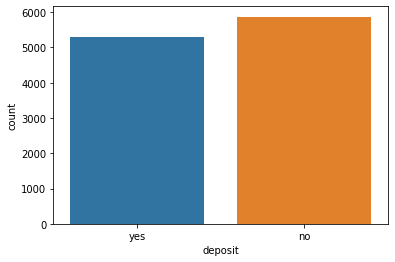

In [279]:
sns.countplot(x='deposit',data=bank)

###  Data Preprocess:
* Splitting
* Feature Selection Transformer
* 

In [280]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def split_data(data,y_label,test_size=0.2):
    bo = uts.booleanEncoder() 
    
    X = data.loc[:,~data.columns.isin([y_label])]
    y = data.loc[:,y_label]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    y_train = bo.fit_transform(y_train)
    y_test = bo.fit_transform(y_test)
    return X_train, X_test,y_train,y_test

def get_metrices(model,X_test,y_test):
    y_predict= model.predict(X_test)
    return accuracy_score(y_test, y_predict),precision_score(y_test, y_predict),recall_score(y_test, y_predict),f1_score(y_test, y_predict)

def print_results(accuracy,precision,recall,f1):
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1: {:.2f}'.format(f1))
    
def descritize_column(column,bins):
    return pd.cut(column.values,bins=bins[column.name],right=False).codes

In [281]:
# import numpy as np
# bins = {
#     'age' : [0,18,30,40,55,np.inf],
#     'balance' :  [0,500,2000,2800,3700,np.inf]
# }
# bank[['age','balance']]=bank[['age','balance']].apply(descritize_column,bins=bins) 
# ui = unknownImputer(nan_column='job',related_column='education')
# bank

In [282]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion
    
numeric_preprocess = Pipeline([('fields',uts.featureSelector(['age','day','duration','campaign','pdays','previous','balance'])),
#                                ("polynomial_features", PolynomialFeatures(degree=3)),
                               ('scaler',StandardScaler())
                              ])

cat_preprocess = Pipeline([('fields',uts.featureSelector(['job','marital','education','contact','poutcome','month'])),
                           ('encoder', OneHotEncoder(sparse=False)),])

boolean_preprocess = Pipeline([('fields',uts.featureSelector(['housing','loan'])),
                               ('encoder',uts.booleanEncoder())])

preprocess_features = FeatureUnion(transformer_list = [
    ('num',numeric_preprocess),
    ('cat',cat_preprocess),
    ('bool',boolean_preprocess)
])

In [283]:
X_train,X_test,y_train,y_test = split_data(bank,'deposit')

In [284]:
X_train = preprocess_features.fit_transform(X_train)
X_test = preprocess_features.transform(X_test)

In [260]:
# X_train = pd.read_csv('./with_clusters/train_data_percentile_clusters.csv')
# X_test = pd.read_csv('./with_clusters/test_data_percentile_clusters.csv')
# t_train= pd.read_csv('./with_clusters/y_train_transformed_percentile.csv')
# t_test= pd.read_csv('./with_clusters/y_test_transformed_percentile.csv')

### Modeling

In [285]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC , LinearSVC
from sklearn.feature_selection import SelectPercentile, SelectFromModel, RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")


select_from_model = SelectFromModel(
   DecisionTreeClassifier(max_depth=10))

model_pipline = Pipeline([
#  ("feature_selection", select_from_model),
#  ('classifier',SVC(kernel='poly',C=10,coef0=1,degree=2))
    ('classifier',XGBClassifier())
#     ('classifier',DecisionTreeClassifier())
 ])

param_grid = [{
#    "feature_selection__percentile": [80],
#     "classifier__n_estimators":[100,200], 
#     "classifier__gamma":[0.001,0.005,0.01],
#     "classifier__gamma":[0,0.5,0.0],
#       "classifier__C":[10,20],
#     "feature_selection__estimator__max_depth": [7,10,15],
    
#     "classifier__max_depth":[30],
 }]

grid_search = GridSearchCV(model_pipline, param_grid, cv=3)
grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
acc,pre,rec,f1 = get_metrices(model,X_test,y_test)
print_results(acc,pre,rec,f1)

[21:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [286]:
model

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

### Results:

In [288]:
# y_predicted = grid_search.decision_function(X_test)
y_predicted = grid_search.predict_proba(X_test)[:,1]

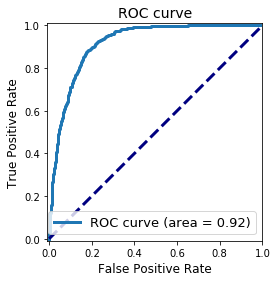

In [289]:
from sklearn.metrics import roc_curve, auc
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_predicted)
roc_auc = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve', fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [290]:
roc_auc

0.9187217973799996

In [291]:
result = {
    'Model':names_parser.get_element_name(model.get_params().get('classifier')),
    'Scaler':names_parser.get_element_name(numeric_preprocess.get_params().get('scaler','-')),
    'Features':names_parser.get_element_params(model.get_params().get('feature_selection','-')),
    'Feature Selection':names_parser.get_element_name(model.get_params().get('feature_selection','')),
    'Accurecy on Test':acc,
    'Recall':rec,
    'Precession':pre,
    'Parameters':names_parser.get_element_params(model.get_params().get('classifier')),
    'Polynomial Features':names_parser.get_element_params(numeric_preprocess.get_params().get('polynomial_features','-')),
    'Roc AUC':roc_auc
}
results_management.add_to_results(result=result).tail(10)

,Model,Scaler,Features,Feature Selection,Accurecy on Test,Recall,Precession,Parameters,Polynomial Features,Roc AUC
42,DecisionTreeClassifier,StandardScaler,percentile=60,SelectPercentile,0.785043,0.816307,0.754113,max_depth=7,-,NaN
43,DecisionTreeClassifier,StandardScaler,percentile=50,SelectPercentile,0.799821,0.790066,0.790807,max_depth=7,degree=3,NaN
44,DecisionTreeClassifier,StandardScaler,percentile=80,SelectPercentile,0.813704,0.814433,0.799448,max_depth=7,degree=4,NaN
45,DecisionTreeClassifier,-,percentile=50,SelectPercentile,0.808330,0.799438,0.799438,max_depth=7,degree=3,NaN
46,DecisionTreeClassifier,-,percentile=80,SelectPercentile,0.807882,0.835052,0.778846,max_depth=7,degree=4,NaN
47,RandomForestClassifier,RobustScaler,percentile=60,SelectPercentile,0.806538,0.816307,0.786811,max_depth=10,-,NaN
48,RandomForestClassifier,RobustScaler,percentile=80,SelectPercentile,0.810121,0.824742,0.787825,max_depth=15,-,NaN
49,RandomForestClassifier,RobustScaler,-,-,0.811912,0.819119,0.793824,max_depth=15,-,NaN
50,RandomForestClassifier,MinMaxScaler,-,-,0.807882,0.812559,0.791058,max_depth=10,-,NaN
51,XGBClassifier,StandardScaler,-,-,0.846843,0.866917,0.822222,"base_score=0.5,booster='gbtree',colsample_byle...",-,0.918722


In [293]:
results_management.save_results()

In [295]:
pd.DataFrame(results_management.results.loc[51])

,51
Model,XGBClassifier
Scaler,StandardScaler
Features,-
Feature Selection,-
Accurecy on Test,0.846843
Recall,0.866917
Precession,0.822222
Parameters,"base_score=0.5,booster='gbtree',colsample_byle..."
Polynomial Features,-
Roc AUC,0.918722
